In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyrosm.data import sources
from pyrosm import get_data
from pyrosm import OSM
from shapely.ops import nearest_points

//home/anatoly/HDD/anaconda3/envs/mlforair/lib/python3.7/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
#fp = get_data('Moscow')
fp = '../DATA/raw/planet_37.15_55.486_4cd95583.osm.pbf'

In [3]:
osm = OSM(fp)

In [4]:
msk_parks = osm.get_data_by_custom_criteria(
    custom_filter={'leisure': ['park', 'garden'], 'natural': ['wood']},
    filter_type='keep',
    keep_nodes = False,
    keep_ways = True,
    keep_relations=True
)

In [5]:
msk_parks = msk_parks[msk_parks.to_crs("EPSG:3395").area > 100000]

In [6]:
my_filter = {"highway": ["trunk", "primary", "secondary"]}

drive_net = osm.get_data_by_custom_criteria(custom_filter=my_filter)

In [7]:
my_filter = {"landuse": ["industrial"]}

indust = osm.get_data_by_custom_criteria(custom_filter=my_filter)

In [8]:
sensors = pd.read_csv('sensors.csv')

In [9]:
sensors = sensors[37.1<=sensors.lon]
sensors = sensors[sensors.lon<=38.05]
sensors = sensors[55.48<=sensors.lat]
sensors = sensors[sensors.lat<=59.03]

In [10]:
sensors = gpd.GeoDataFrame(sensors, geometry=gpd.points_from_xy(sensors.lon, sensors.lat))
sensors['geometry'] = sensors.geometry.set_crs(epsg=4326)

<AxesSubplot:>

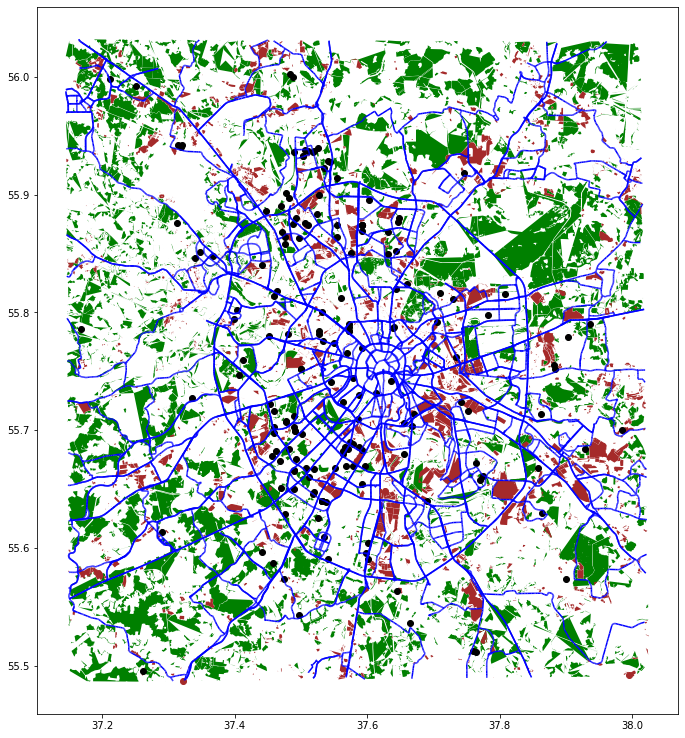

In [11]:
ax = drive_net.plot(figsize=(13,13), color="blue")
ax = msk_parks.plot(ax=ax, color="green")
ax = indust.plot(ax=ax, color="brown")
sensors.plot(ax=ax, color='black')

In [12]:
def nearest(row, geom):
    nearest = nearest_points(row, geom)[1]
    return nearest

In [13]:
union = msk_parks.centroid.unary_union

//home/anatoly/HDD/anaconda3/envs/mlforair/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [14]:
sensors['nearest_park'] = sensors.geometry.apply(nearest, geom=union)

In [15]:
sensors['nearest_park'] = sensors.geometry.to_crs("EPSG:3395").distance(sensors.nearest_park.to_crs("EPSG:3395"))

In [16]:
drive_union = drive_net.geometry.unary_union

In [17]:
sensors['nearest_road'] = sensors.geometry.apply(nearest, geom=drive_union)

In [18]:
sensors['nearest_road'] = sensors.geometry.to_crs("EPSG:3395").distance(sensors.nearest_road.to_crs("EPSG:3395"))

In [19]:
indust_union = indust.centroid.unary_union

//home/anatoly/HDD/anaconda3/envs/mlforair/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [20]:
sensors['nearest_indust'] = sensors.geometry.apply(nearest, geom=indust_union)

In [21]:
sensors['nearest_indust'] = sensors.geometry.to_crs("EPSG:3395").distance(sensors.nearest_indust.to_crs("EPSG:3395"))

(<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>)

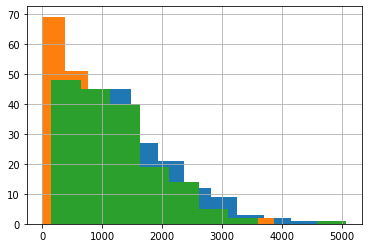

In [22]:
sensors.nearest_park.hist(), sensors.nearest_road.hist(), sensors.nearest_indust.hist()

In [23]:
sensors.head()

,sds_sensor,bme_sensor,lat,lon,sealevel,surface_alt,surface_level,geometry,nearest_park,nearest_road,nearest_indust
0,43811,43812,55.703017,37.459441,198.129123,163.0,35.129123,POINT (37.45944 55.70302),708.707392,112.194727,1342.638505
1,46280,46281,55.677867,37.456325,179.383064,176.0,3.383064,POINT (37.45633 55.67787),1658.169550,864.642229,1458.923855
2,33626,33627,55.874089,37.510001,167.849245,176.0,-8.150755,POINT (37.51000 55.87409),1425.563323,1014.471402,492.095085
3,54815,54816,55.752000,37.884000,229.558872,153.0,76.558872,POINT (37.88400 55.75200),1948.474417,478.007954,702.114877
4,45568,45569,55.625773,37.525268,263.580603,230.0,33.580603,POINT (37.52527 55.62577),1132.250738,1411.553491,2967.174366


In [24]:
len(sensors)

174

In [25]:
sensors.to_csv('sensors.csv', index=False)